<div class="alert alert-block alert-info">
<h1>Forecasting electricity consumption using time series</h1>

The file Elec-train.xlsx contains electricity consumption (kW) and outdoor air temperature for one building.
These quantities are measured every 15 minutes, from 1/1/2010 1:15 to 2/16/2010 23:45. In addition, outdoor
air temperature are available for 2/17/2010. The goal is to forecast electricity consumption (kW) for
2/17/2010.
Two forecasts should be returned, in one Excel file entitled YourName.xlsx, with two columns (one columns
per forecast) and 96 rows:
1. the first one without using outdoor temperature,
2. the second one using outdoor temperature.

Of course, the goal is to get the best possible forecasting. 

So, in addition to your forecast, you should also return a short reports (few pages), entitled YourName.pdf, explaining how you have proceeded.

<h1>PART I: without using outdoor temperature</h1>

<font color ='blue'><h2> Analysing Data</h2></font>

In [110]:
library(openxlsx)
library(xts)
library(forecast)
library(fpp)
library(ggplot2)

In [111]:
data = read.xlsx('data/Elec-train.xlsx', sheet = 1)

In [112]:
data[,1] = as.POSIXct(data[,1], format='%m/%d/%Y %H:%M')

In [113]:
elect = xts(data[,2], order.by = data[,1], frequency = 4)
elect = na.omit(elect)

In [114]:
options(repr.plot.width=15, repr.plot.height=10)

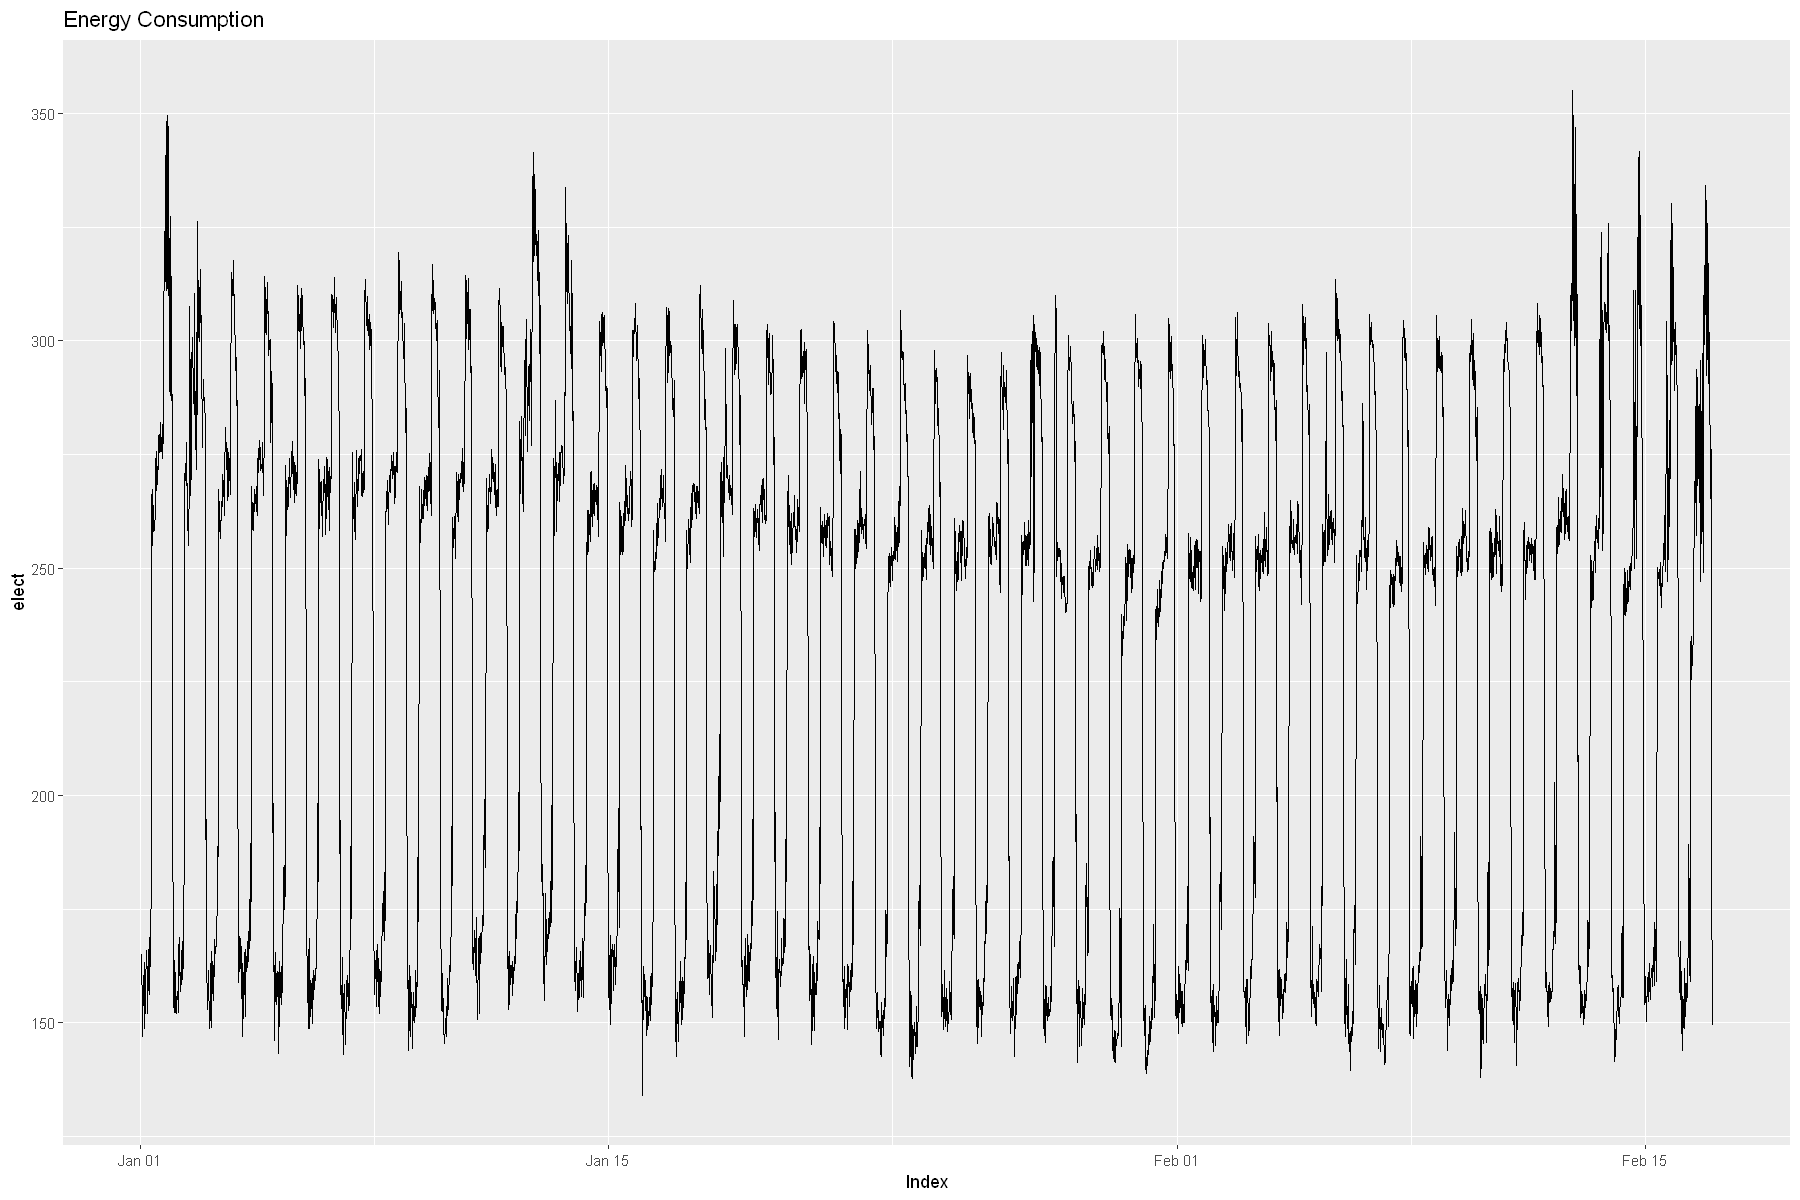

In [115]:
autoplot(elect, main="Energy Consumption")

It seems that our series has no trend, but a seasonal pattern.

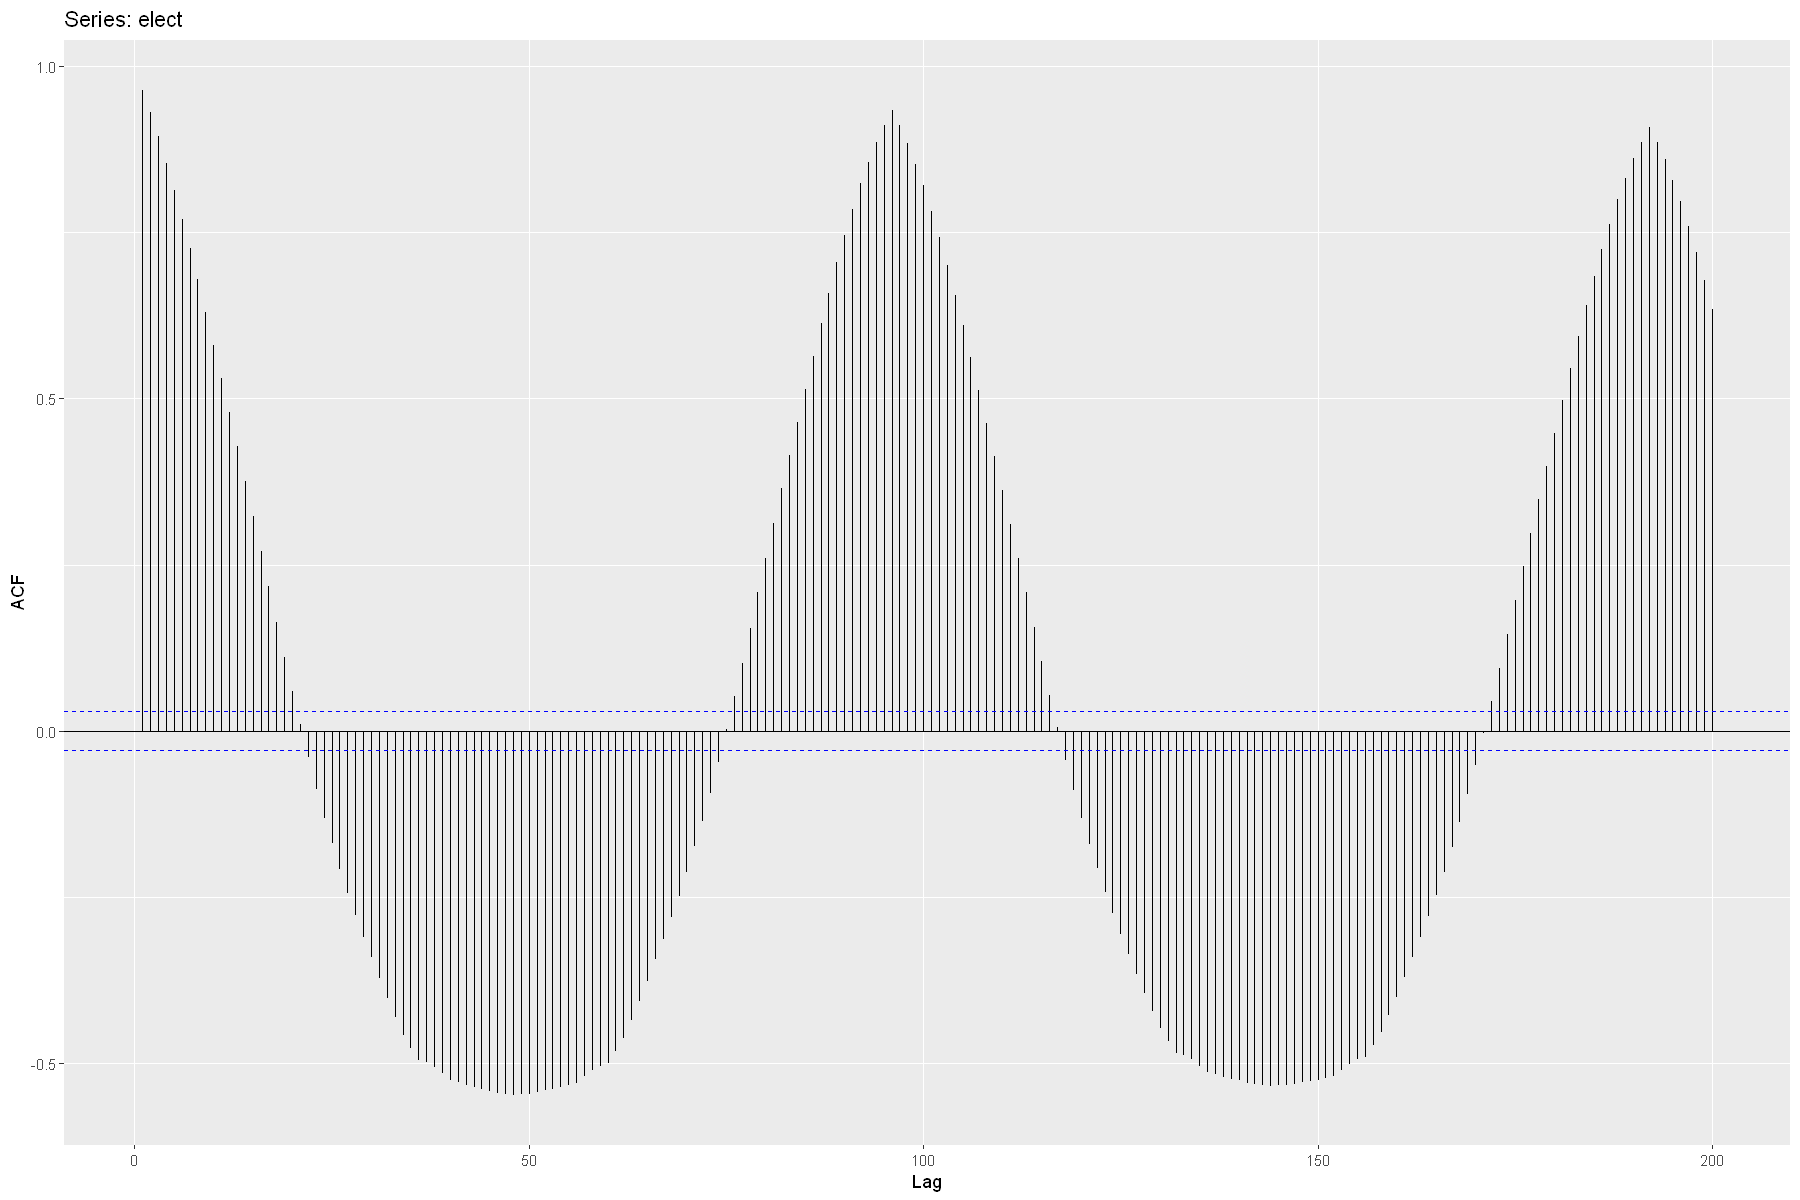

In [116]:
ggAcf(elect, type="correlation", plot = TRUE, lag.max=200)

Analysing the ACF we see a seasonal pattern of period 96.

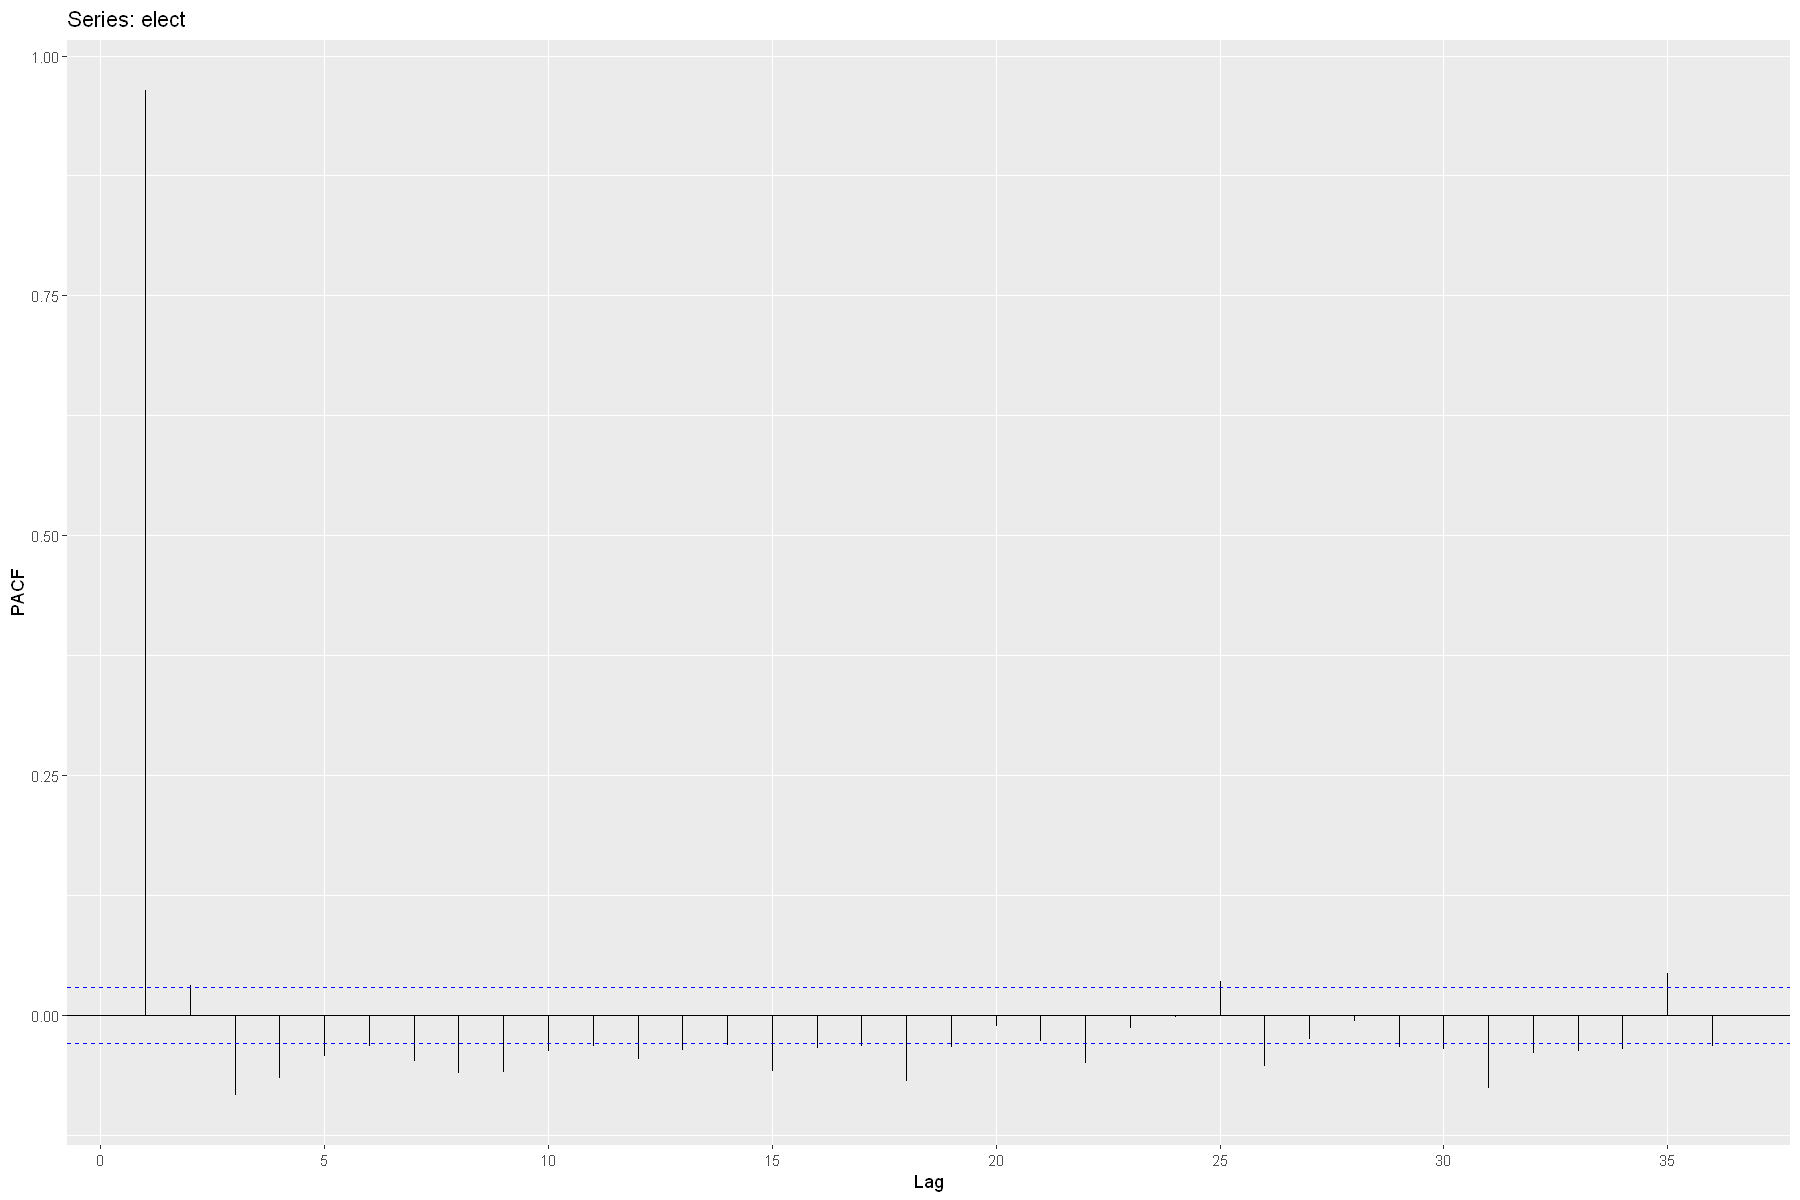

In [117]:
ggPacf(elect, plot = TRUE)

Warning message:
"Removed 96 rows containing missing values (geom_point)."


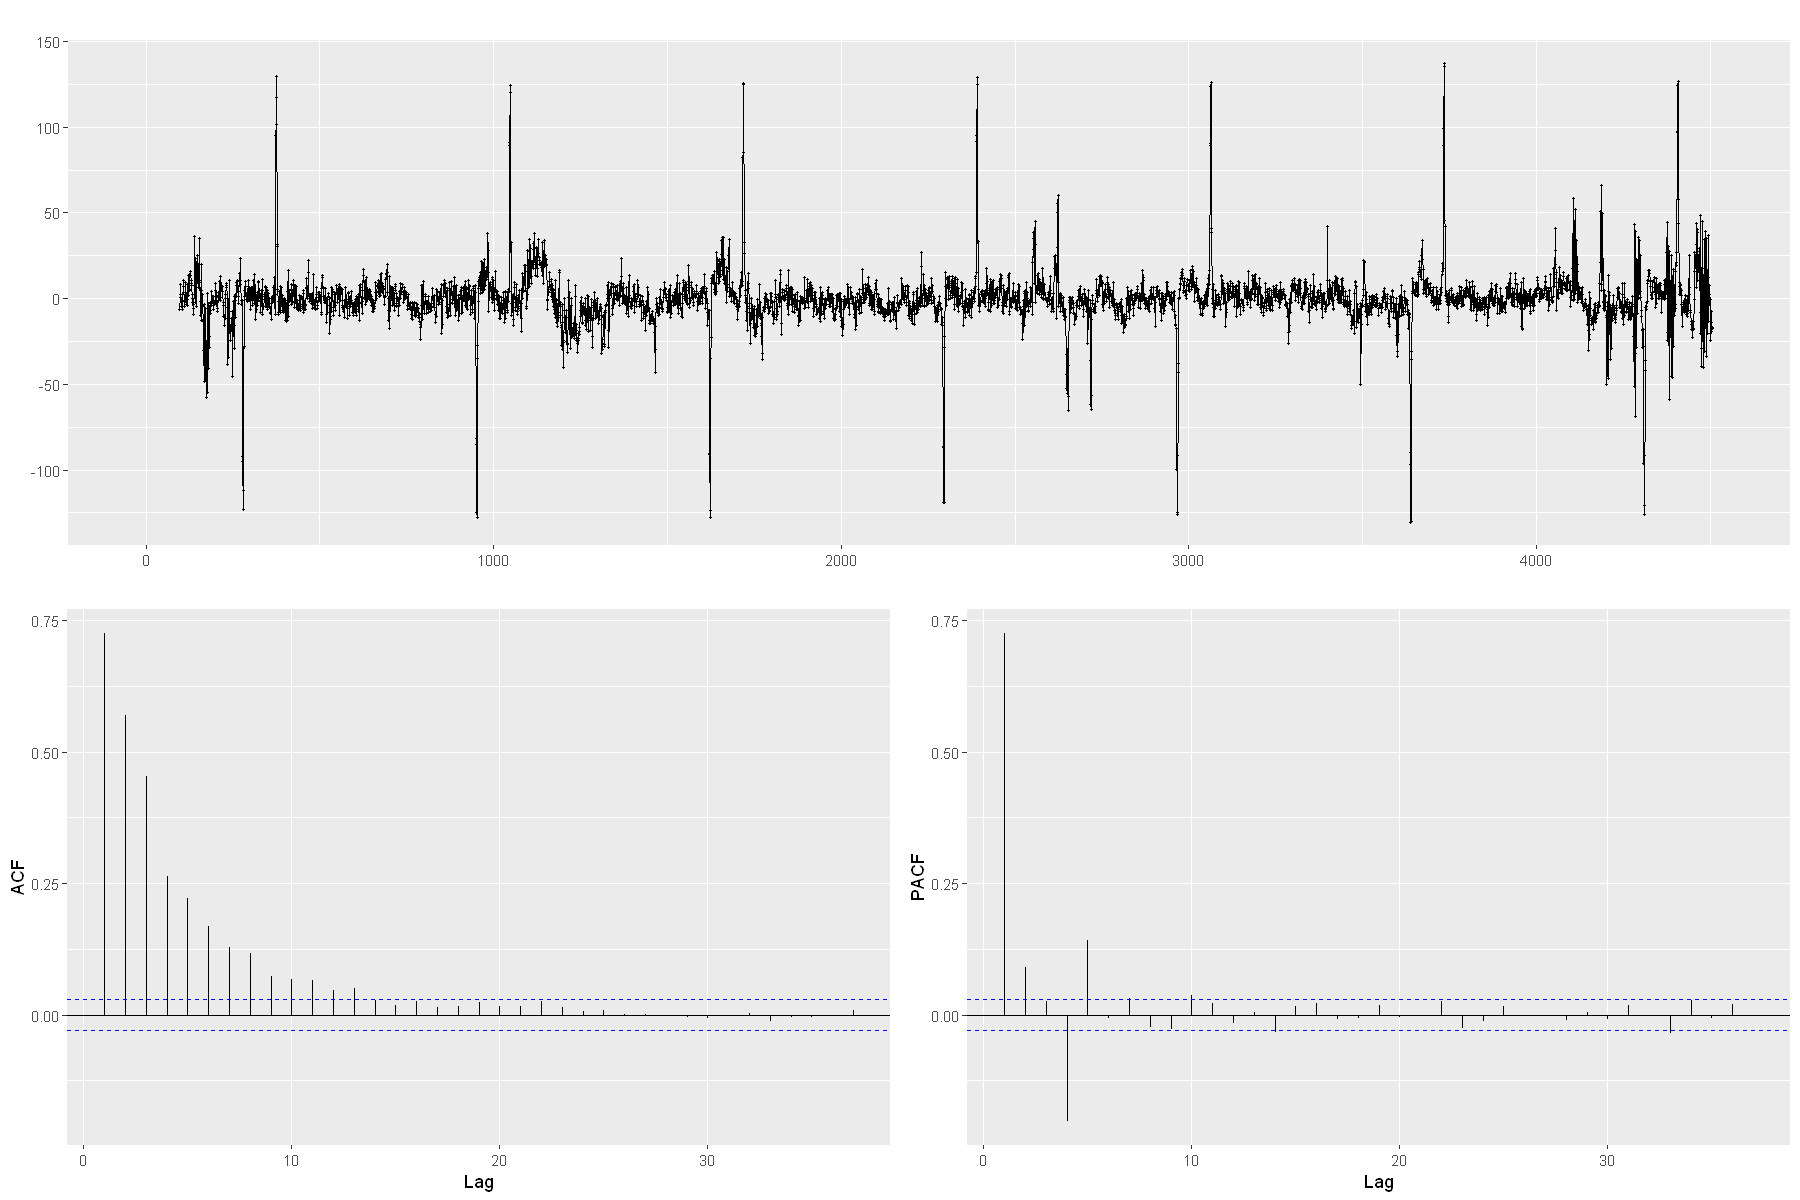

In [118]:
elect %>% diff(lag = 96) %>% ggtsdisplay()

In [119]:
Box.test(diff(elect, lag=96), type="Ljung-Box")


	Box-Ljung test

data:  diff(elect, lag = 96)
X-squared = 2325.8, df = 1, p-value < 2.2e-16


<b>Conclusion: </b>
- After removing the seasonality using lag = 96 we obtain a stationary residual. By the Box-Ljung test we confirm that the residuals are not white noise;
- This series has no trend, so we don't apply differences because it is not going to help to build the model;
- The ACF has an exponential decrease, and should be modeled by an autoregressive model.

In [120]:
train = ts(head(elect,4411), frequency = 96)
test = tail(elect,96)

<font color ='blue'><h2> Modeling </h2></font>

<h2>SARIMA</h2>

As we have seasonality on our data we are going to try to apply a seasonal ARIMA:

In [121]:
AUTO_ARIMA_MODEL = auto.arima(train)
AUTO_ARIMA_MODEL

Series: train 
ARIMA(5,0,0)(0,1,0)[96] 

Coefficients:
         ar1     ar2     ar3      ar4     ar5
      0.7198  0.0611  0.1086  -0.2604  0.1231
s.e.  0.0151  0.0182  0.0182   0.0183  0.0153

sigma^2 estimated as 112.7:  log likelihood=-16313.96
AIC=32639.92   AICc=32639.94   BIC=32678.14

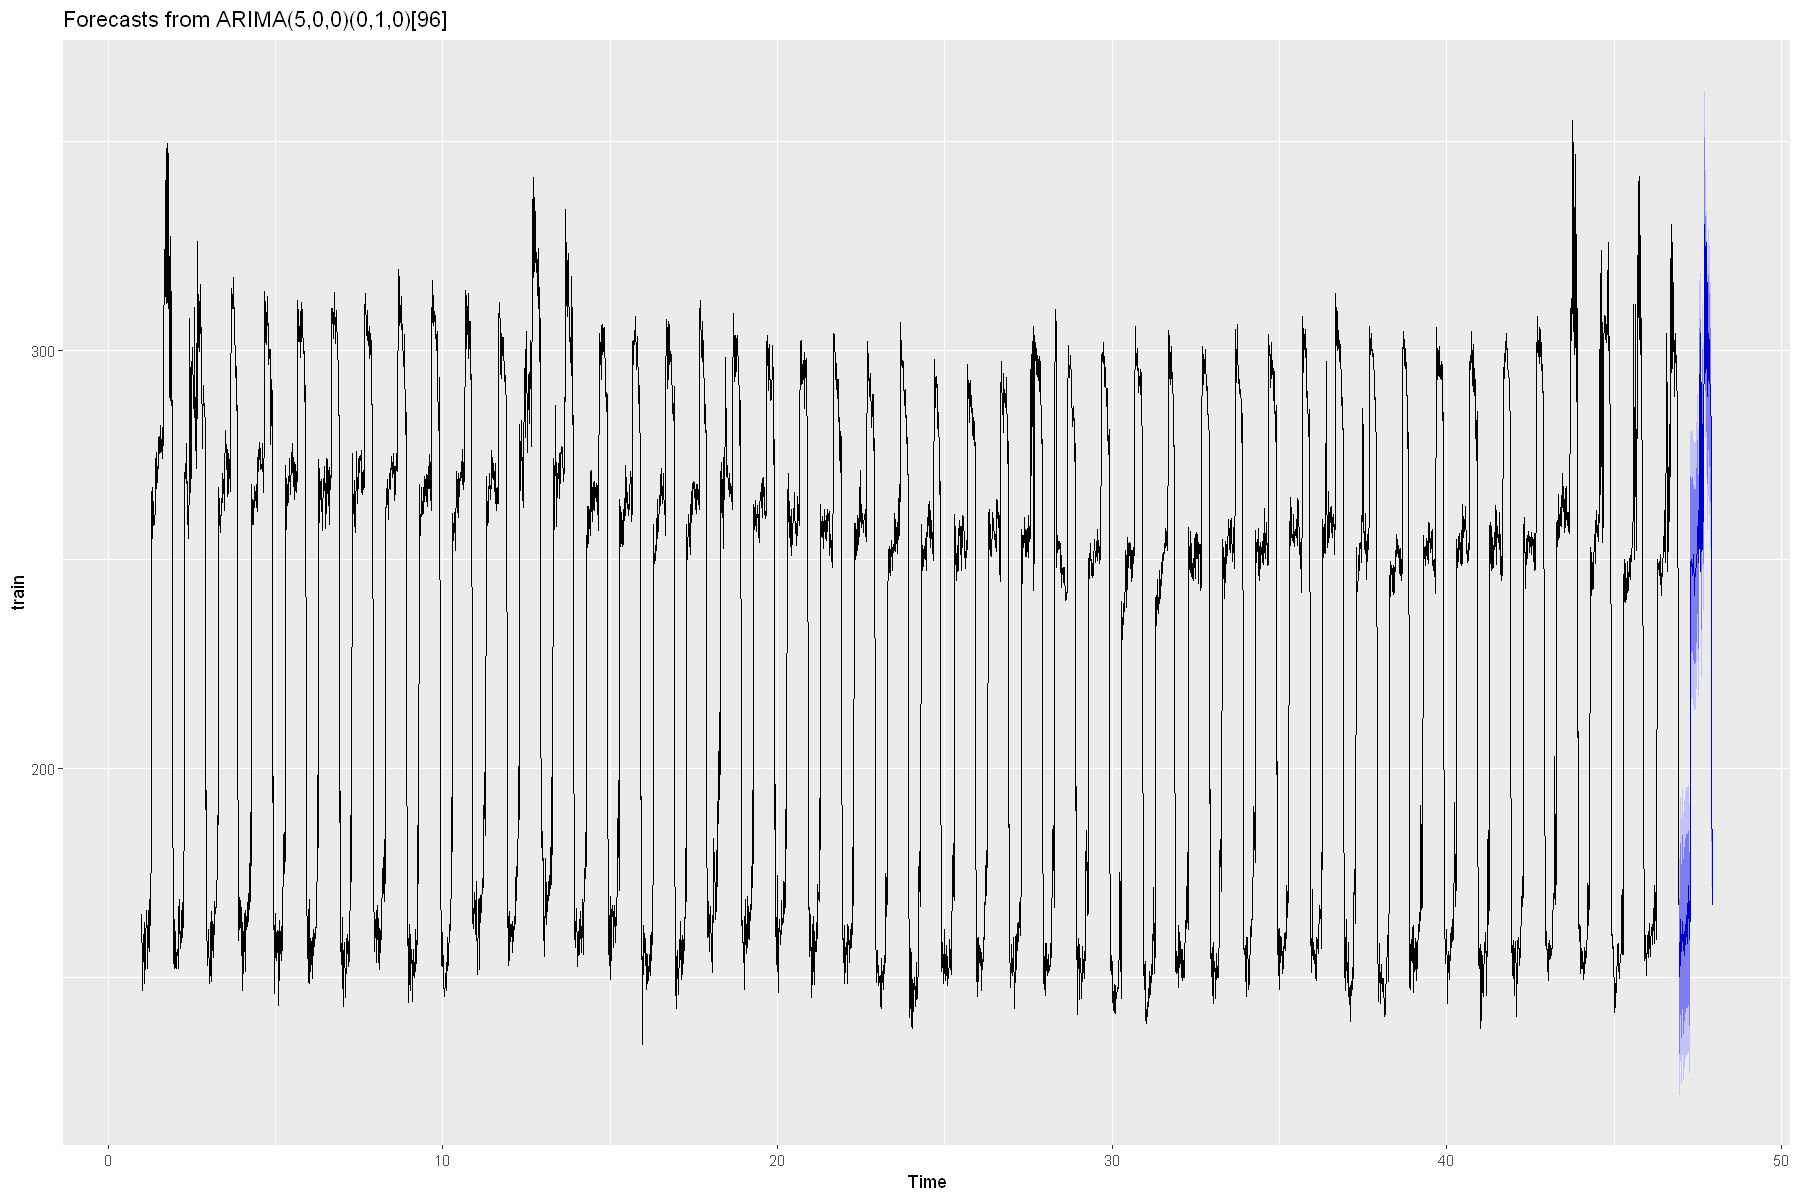

In [122]:
autoplot(forecast(AUTO_ARIMA_MODEL, h=96))

Trying different configuration base on ACF and PACF:

- ARIMA(5,1,5)(1,0,0)96

In [123]:
p = 5
d = 1
q = 5
P = 1
D = 0
Q = 0
Arima(train, order=c(p,d,q), seasonal=c(P,D,Q))

Warning message in sqrt(diag(x$var.coef)):
"NaNs produced"


Series: train 
ARIMA(5,1,5)(1,0,0)[96] 

Coefficients:
         ar1      ar2     ar3     ar4    ar5      ma1    ma2     ma3      ma4
      0.4655  -0.1885  0.0175  0.0738  0.272  -0.6903  0.209  0.0140  -0.3652
s.e.  0.0571   0.0109  0.0410     NaN    NaN   0.0613  0.022  0.0323      NaN
          ma5    sar1
      -0.1675  0.7953
s.e.      NaN  0.0045

sigma^2 estimated as 103:  log likelihood=-16521.28
AIC=33066.56   AICc=33066.63   BIC=33143.26

- ARIMA(5,1,3)(1,0,0)96

<h2>Additive seasonal Holt-Winters</h2>

Lets try the additive seasonal Holt-Winters that considers a linear trend plus a seasonal pattern. The option for the additive one comes from the fact that we don't observe increase in the variance throughout the period.

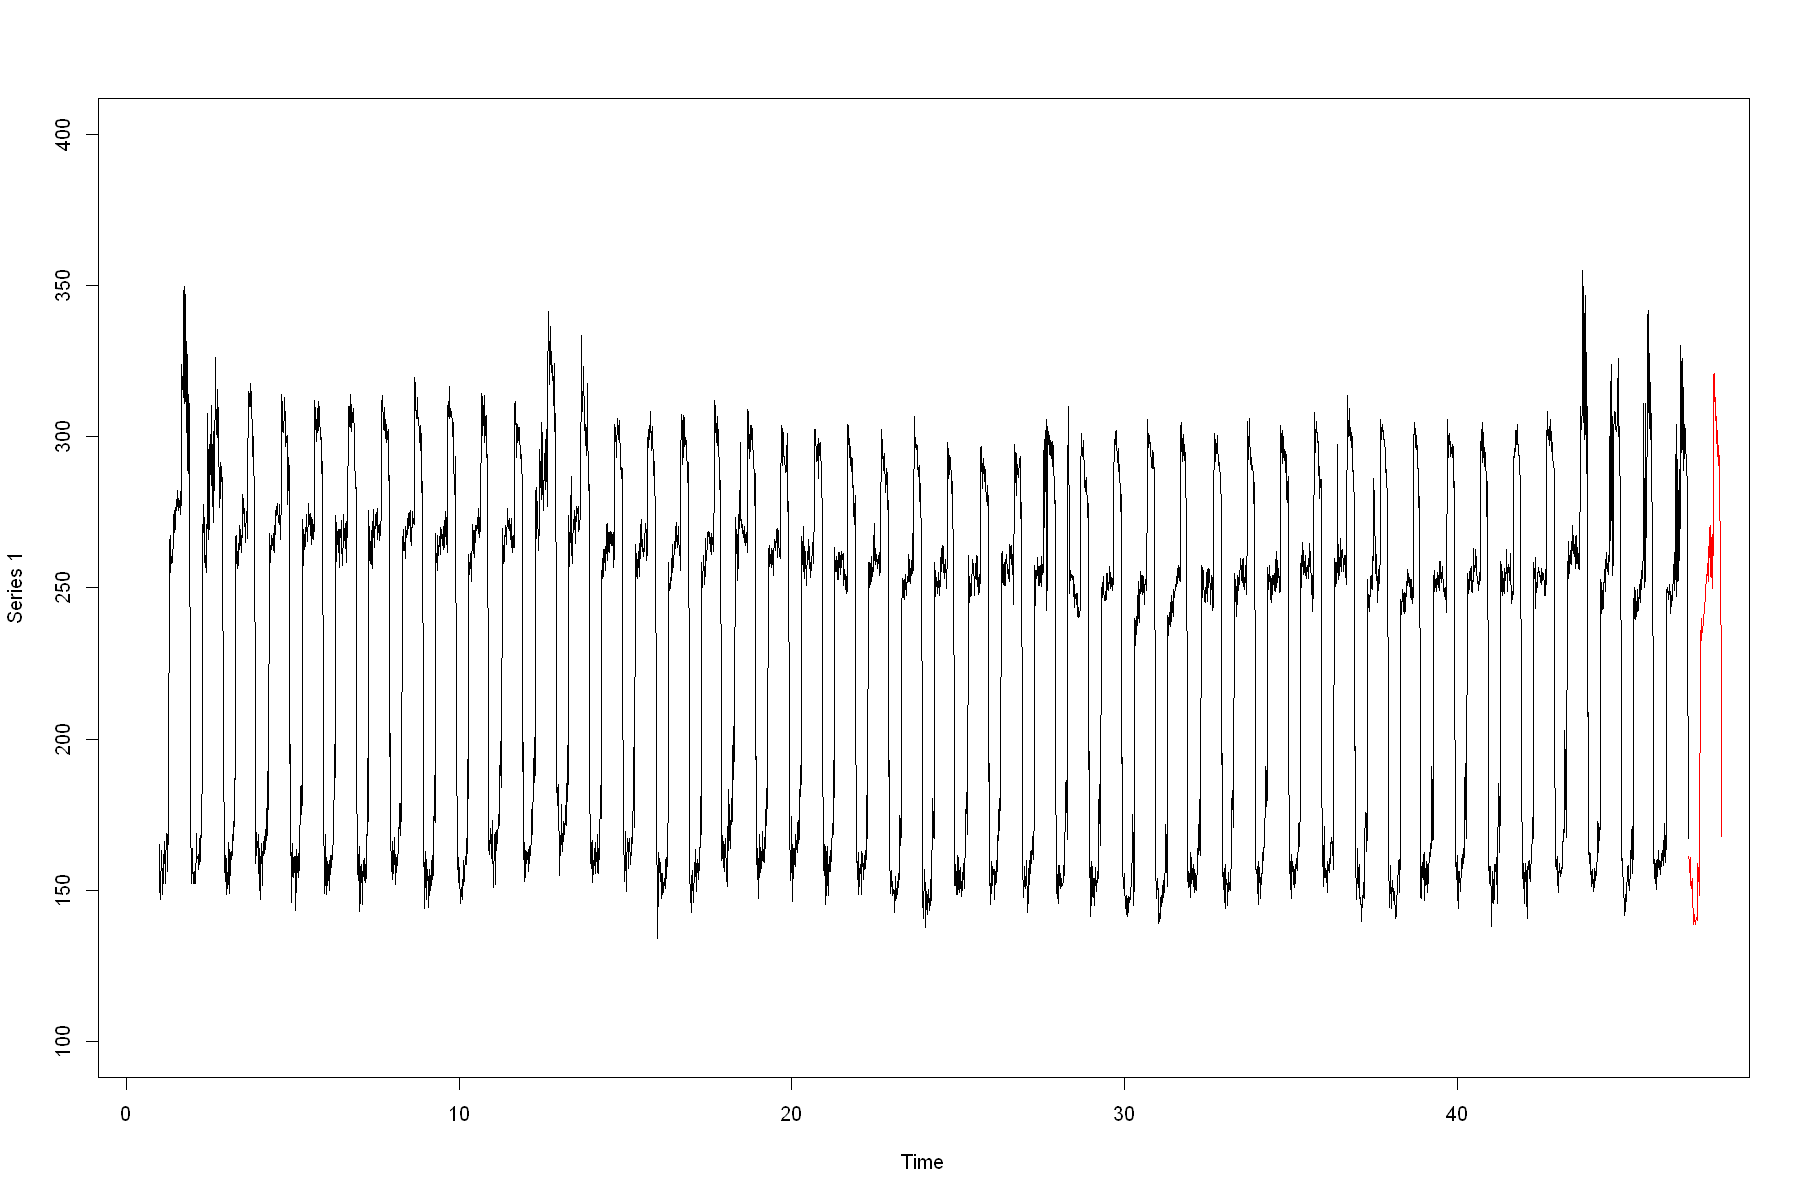

In [124]:
ADD_SEASONAL_HOLT_WINTERS = HoltWinters(train,alpha=NULL,beta=NULL,gamma=NULL)
plot(train,ylim=c(100,400))
p <- predict(ADD_SEASONAL_HOLT_WINTERS, n.ahead=96)
lines(p,col=2)

<h2>Neural Network Auto-Regression (NNAR)</h2>

Lets try a neural network, but considering that we don't have any cyclic pattern maybe the result will not be so good as the previous models.

<b>- Using p and P from the ARIMA model</b>

In [125]:
ANN = nnetar(train, 5, 1, size=5)
print(ANN)

Series: train 
Model:  NNAR(5,1,5)[96] 
Call:   nnetar(y = train, p = 5, P = 1, size = 5)

Average of 20 networks, each of which is
a 6-5-1 network with 41 weights
options were - linear output units 

sigma^2 estimated as 85.01


<b>- Using automatic configuration</b>

In [126]:
ANN = nnetar(train)
print(ANN)

Series: train 
Model:  NNAR(11,1,6)[96] 
Call:   nnetar(y = train)

Average of 20 networks, each of which is
a 12-6-1 network with 85 weights
options were - linear output units 

sigma^2 estimated as 78.21


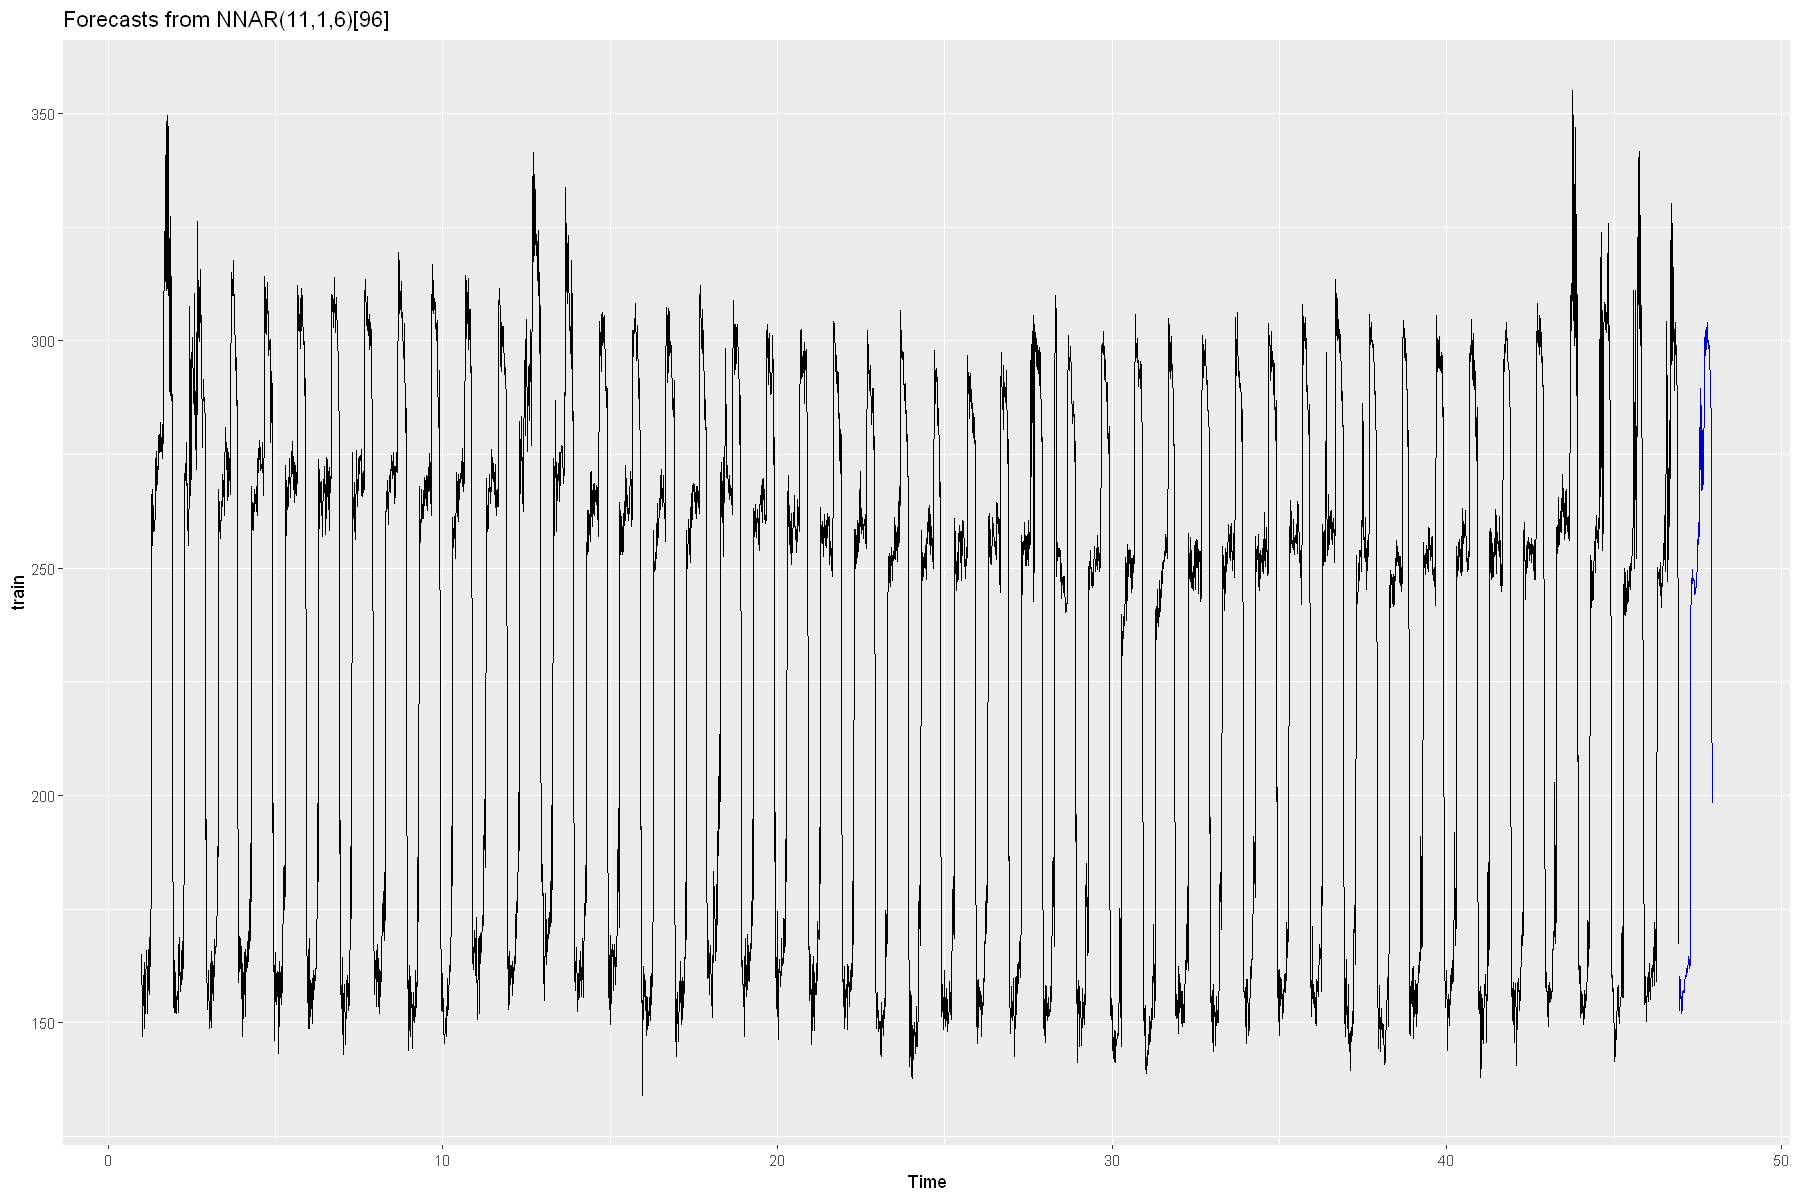

In [127]:
autoplot(forecast(ANN, h=96))

In [128]:
RMSE <- function(MODEL, test) {
  predicted_value=forecast(MODEL,h=length(test))
  return (sqrt(mean((predicted_value$mean-as.numeric(test))^2)))
}

In [129]:
RMSE(AUTO_ARIMA_MODEL, test)

[1] 19.78907

In [130]:
RMSE(ADD_SEASONAL_HOLT_WINTERS, test)

[1] 16.86543

In [131]:
RMSE(ANN, test)

[1] 18.42125

In [132]:
data.frame(model = c('ARIMA','Additive seasonal Holt-Winters', 'ANN'), 
           Mean_Squared_Error = c(RMSE(AUTO_ARIMA_MODEL, test), RMSE(ADD_SEASONAL_HOLT_WINTERS, test), RMSE(ANN, test)))

model,Mean_Squared_Error
<fct>,<dbl>
ARIMA,19.78907
Additive seasonal Holt-Winters,16.86543
ANN,18.42125


<b>Conclusion: </b>In the models tests the best result was obtained using Additive seasonal Holt-Winters.

In [133]:
ADD_SEASONAL_HOLT_WINTERS = HoltWinters(elect,alpha=NULL,beta=NULL,gamma=NULL)
plot(elect,ylim=c(100,400))
p <- predict(ADD_SEASONAL_HOLT_WINTERS, n.ahead=96)
lines(p,col=2)

ERROR: Error in decompose(ts(x[1L:wind], start = start(x), frequency = f), seasonal): time series has no or less than 2 periods


<hr>
<h1>PART II: using outdoor temperature</h1>

In [ ]:
data = read.xlsx('data/Elec-train.xlsx', sheet = 1)
data[,1] = as.POSIXct(data[,1], format='%m/%d/%Y %H:%M')

In [ ]:
elect = xts(data[,2:3], order.by = data[,1], frequency = 4)
elect = na.omit(elect)

<font color ='blue'><h2> Analysing Data</h2></font>

In [ ]:
autoplot(elect$`Temp.(C°)`)

In [ ]:
train = ts(head(elect,4411), frequency = 96)
test = tail(elect,96)

In [ ]:
plot(train[,2],train[,1], xlab="Temperature", ylab="Consumption")

It seem that we don't have a linear relationship between temperatute and consumption.

<font color ='blue'><h2>Modeling</h2></font>

<h3>Time series regression models</h3>

Lets check if our intuition was right about a linear model being inappropriate. Considering that our model has seasonality we add it to the linear model.

In [ ]:
LINEAR_MODEL=tslm(train[,1]~train[,2]+season, data=train)
summary(LINEAR_MODEL)

Looking at the p-values we see that in the linear model the temperature (train[,2]) has no effect on the model.

<h3>Dynamic regression model</h3>

In [ ]:
DRM = Arima(train[,1],xreg=train[,2],order=c(5,0,0),  seasonal = c(0,1,0))
summary(DRM)

In [ ]:
checkresiduals(DRM,test=FALSE)

In [ ]:
Box.test(DRM$residuals, type="Ljung-Box")

We can see that the residuals of the model are only white noise, such that we have a model that treats all the characteristics of the series.

In [ ]:
autoplot(forecast(DRM,xreg=rep(mean(train[,2]),96)))

In [ ]:
predicted_value=forecast(DRM,xreg=rep(mean(train[,2]),96))
sqrt(mean((predicted_value$mean-as.numeric(test[,1]))^2))

<b>Conclusion:</b> The model used in dynamic is good, but not as good as the seasonal Holt-Winters.